In [1]:
import numpy as np
from qiskit import *
from qiskit.providers.fake_provider import FakeManila, FakeKolkata, FakeMelbourne
from mthree.twirling.twirl_circuit import texmex_data
from mthree.utils import final_measurement_mapping
from mthree import M3Mitigation
from mthree.calibrations import Calibration
from mthree.generators import CompleteGenerator, HadamardGenerator, RandomGenerator
import matplotlib.pyplot as plt
from mthree.utils import expval

In [2]:
backend = FakeKolkata()

In [3]:
def donothing(N):
    qc = QuantumCircuit(N, N)
    for i in range(N):
        qc.measure(i,i)
    return qc

def GHZ(N):
    qc = QuantumCircuit(N, N)
    qc.h(0)
    for i in range(1,N):
        qc.cx(0,i)
    for i in range(N):
        qc.measure(i,i)
    return qc

def m3circuit(N):
    qc = QuantumCircuit(N, N)
    qc.x(range(N))
    qc.h(range(N))
    for kk in range(N // 2, 0, -1):
        qc.ch(kk, kk - 1)
    for kk in range(N // 2, N - 1):
        qc.ch(kk, kk + 1)
    for i in range(N):
        qc.measure(i,i)
    return qc

In [4]:
# from qiskit import Aer
# from qiskit.visualization import plot_histogram
# from qiskit_aer import AerSimulator
# import qiskit_aer.noise as noise

# bit_flip_prob = 0.02  # bit flip readout

# # Build noise model from backend properties
# backend = FakeKolkata()
# noise_model = NoiseModel.from_backend(backend)
# num_backend_qubits = system_info(backend)["num_qubits"]

# # Error probability
# readout_probabilities = [[1-bit_flip_prob, bit_flip_prob], [bit_flip_prob, 1-bit_flip_prob]]   # measurement error 

# # Readout quantum errors
# readout_error = noise.ReadoutError(readout_probabilities)

# # Add errors to noise model
# noise_model = noise.NoiseModel()
# noise_model.add_all_qubit_readout_error(readout_error)

# # Get basis gates from noise model
# basis_gates = noise_model.basis_gates

In [5]:
def unmitig_mitig_expval(N, trials):
    unmitig_expvals = []
    mitig_expvals = []

    op = N*'Z'
    qc = GHZ(N)
    transpiled_circuit = transpile(qc, backend)
    measurement_map = final_measurement_mapping(transpiled_circuit)
    qubits = [value for key,value in measurement_map.items()]

    for i in range(trials):
        result = backend.run(transpiled_circuit, shots=2**13).result()
        counts = result.get_counts()
        unmitig_val = expval(items=counts, exp_ops=op)
        unmitig_expvals.append(unmitig_val)

        cal = Calibration(backend=backend,qubits=qubits)
        cal.calibrate_from_backend(shots=2**13)
        texmex_counts = texmex_data(backend=backend, circuit=transpiled_circuit, shots=2**13)

        mitig_val = cal.mitigated_expval(texmex_counts,qubits,op)
        mitig_expvals.append(mitig_val)
    
    return [np.average(unmitig_expvals), np.std(unmitig_expvals), np.average(mitig_expvals), np.std(mitig_expvals)]

In [6]:
unmitig_mitig_expval(N=4, trials=10)

[0.9208251953125,
 0.004703811240587015,
 0.9773361316870657,
 0.004418276233711646]

In [18]:
# N_range = [2,4,6,8,10]
# unmitig_vals = []
# unmitig_stds = []
# mitig_vals = []
# mitig_stds = []

# for qubits in N_range:
#     result = unmitig_mitig_expval(N=qubits, trials=10)
#     unmitig_vals.append(result[0])
#     unmitig_stds.append(result[1])
#     mitig_vals.append(result[2])
#     mitig_stds.append(result[3])

In [21]:
N_range = [2,4,6,8,10]
unmitig_vals = [0.94599609375, 0.9210693359375, 0.8398681640625, 0.777490234375, 0.668896484375]
unmitig_stds = [0.0025993811824621418, 0.0030747183135735713, 0.005093653484904503, 0.007427013024152947, 0.009014576446011014]
mitig_vals = [0.9920479223485353, 0.9792045755064119, 0.9327930666873868, 0.8802839067142113, 0.8103873867095439]
mitig_stds = [0.004302295271747347, 0.0047755711395366775, 0.005256433046445061, 0.011830690154842666, 0.008032478239274261]

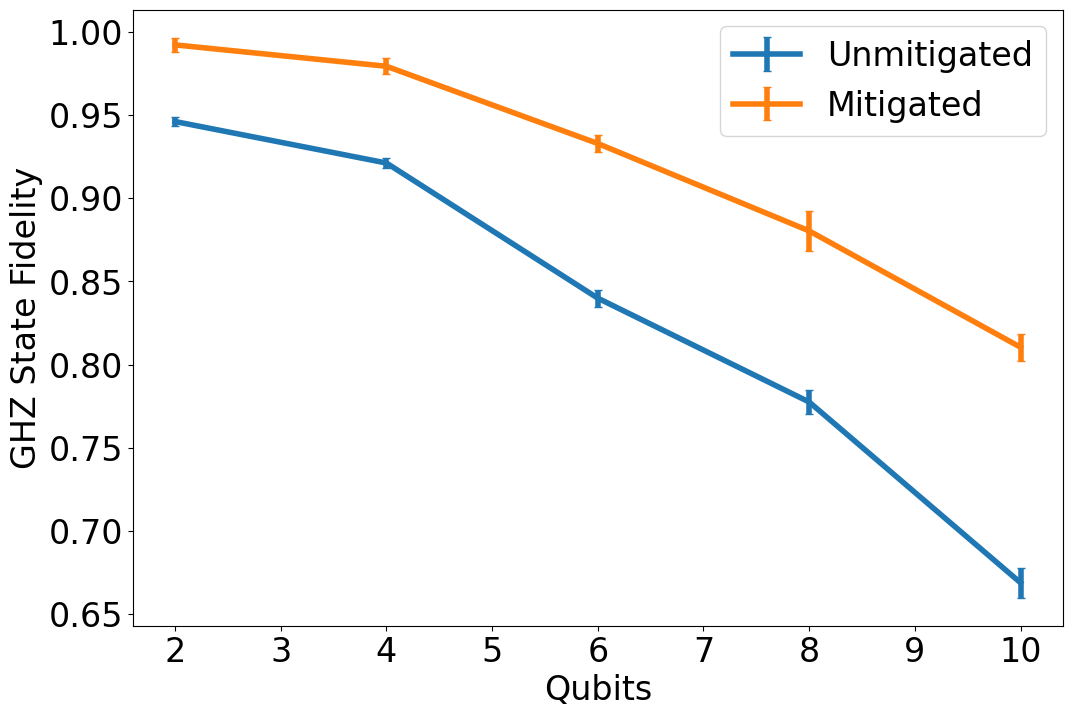

In [26]:
plt.figure(figsize=(12,8))
plt.rcParams['font.size'] = 24
plt.errorbar(N_range, unmitig_vals, yerr=unmitig_stds, capsize=3, label='Unmitigated', linewidth=4)
plt.errorbar(N_range, mitig_vals, yerr=mitig_stds, capsize=3, label='Mitigated', linewidth=4)
plt.xlabel('Qubits')
plt.ylabel('GHZ State Fidelity')
plt.legend()
#plt.savefig("fidelity.jpg",bbox_inches ="tight", transparent = True)
plt.show()